# DONUT: the Document Understanding Transformer

## 1. Preparing the dataset

Donut expects paired image-text data for training, where the images are document images (receipts in your case) and the corresponding text is structured in JSON format.

In [15]:
!pip install transformers datasets

In [16]:
import pandas as pd
import json
import os
from PIL import Image
from datasets import Dataset
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


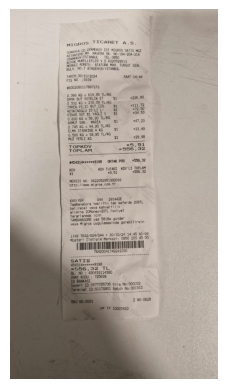

{
  "location": "AISANTEPE MH. MAVERA SK. No 194\u00b0 20K 21- bi, NERMEKOY, ISTANBUL",
  "shop": "MIGROS",
  "datetime": "30/10/21 14:45",
  "items": [
    {
      "name": "DANA BUT SOTELIK ET",
      "quantity": 0.366,
      "unitprice": 619.95,
      "amount": 226.9,
      "category": "chicken_and_meat"
    },
    {
      "name": "IMREN PILIC BUT IZG.",
      "quantity": 0.532,
      "unitprice": 210.0,
      "amount": 111.72,
      "category": "chicken_and_meat"
    },
    {
      "name": "KESKINOGLU 15\u00b0LE L",
      "quantity": 1,
      "unitprice": 72.5,
      "amount": 72.5,
      "category": "chicken_and_meat"
    },
    {
      "name": "PINAR SUT 81 YAGLI",
      "quantity": 1,
      "unitprice": 34.5,
      "amount": 34.5,
      "category": "dairy"
    },
    {
      "name": "ARMUT SAN. MARIA",
      "quantity": 0.83,
      "unitprice": 56.9,
      "amount": 47.23,
      "category": "produce"
    },
    {
      "name": "ELMA STARKING",
      "quantity": 0.745,
      "unit

In [17]:
is_colab = 'google.colab' in str(get_ipython())

if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')



data_path = '/content/drive/MyDrive/DT-ImageDataExtraction' if is_colab else '.'
os.chdir(data_path)

df = pd.read_csv("./data/receipts_extracted.csv")

def get_example_row(example):
    image_path = example["image_path"].replace("\\", "/")
    return image_path, example["label"]


example_row = df.iloc[21]
image_path, label = get_example_row(example_row)

img = plt.imread(image_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

print(json.dumps(json.loads(label), indent=2))


In [18]:

# Convert to HuggingFace Datasets
dataset = Dataset.from_pandas(df)


In [19]:
dataset

Dataset({
    features: ['image_path', 'text', 'label'],
    num_rows: 225
})

## Tokenization

In [20]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["label"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image_path = sample["image_path"].replace("\\", "/")
    image = Image.open(image_path).convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")


Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Sample: <s><s_shop>Nathalie</s_shop><s_location>15700 Beower Blvd, Bellflower, CA 90706</s_location><s_items><s_quantity>2</s_quantity><s_name>Enchi Omelete SHREDDED BEEF</s_name><s_category>misc</s_category><sep/><s_quantity>1</s_quantity><s_name>Open Food SHREDDED BEEF</s_name><s_category>misc</s_category><sep/><s_quantity>1</s_quantity><s_name>Open Food</s_name><s_category>misc</s_category><sep/><s_quantity>1</s_quantity><s_name>Hashbrowns Side</s_name><s_category>misc</s_category></s_items></s>
New special tokens: ['<s_total>', '</s_total>', '<s_shop>', '</s_shop>', '<s_location>', '</s_location>', '<s_items>', '</s_items>', '<s_unitprice>', '</s_unitprice>', '<s_quantity>', '</s_quantity>', '<s_name>', '</s_name>', '<s_category>', '</s_category>', '<s_amount>', '</s_amount>', '<s_discount>', '</s_discount>', '<s_datetime>', '</s_datetime>', '<s_change_due>', '</s_change_due>', '<s_cash_tend>', '</s_cash_tend>', '<s_tax>', '</s_tax>', '<s_payment_method>', '</s_payment_method>', '<

In [32]:
# remove column
proc_dataset = proc_dataset.remove_columns("image_path")
proc_dataset = proc_dataset.remove_columns("label")
proc_dataset

Dataset({
    features: ['text', 'image'],
    num_rows: 225
})

## Tokenize text and encode the images into tensors

In [33]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}


processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:224: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Map:   0%|          | 0/225 [00:00<?, ? examples/s]

## split the data into train and test data

In [34]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)


## Fine-tuning the donut model

In [38]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import os


model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")


new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

os.environ["WANDB_DISABLED"] = "true"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
)

class CustomSeq2SeqTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False, *args, **kwargs):
        #remove num_items_in_batch from inputs
        inputs.pop("num_items_in_batch", None)
        return super().compute_loss(model, inputs, return_outputs=return_outputs)


# Create Trainer
trainer = CustomSeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

trainer.train()

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    2560,
    1920
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.1",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add

Step,Training Loss
100,7.709400
200,5.627200
300,4.626200


TrainOutput(global_step=303, training_loss=5.971137323788684, metrics={'train_runtime': 6731.783, 'train_samples_per_second': 0.09, 'train_steps_per_second': 0.045, 'total_flos': 1.0658860090417152e+18, 'train_loss': 5.971137323788684, 'epoch': 3.0})

## saving the model

In [44]:
# Save the final model locally
output_dir = "./donut_model_receipts"
model.save_pretrained(output_dir)
trainer.save_model(output_dir)
processor.save_pretrained(output_dir)

[]

## Testing and Evaluation

In [40]:
import numpy as np
def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

In [54]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

# hidde logs
transformers.logging.disable_default_handler()


processor = DonutProcessor.from_pretrained("./donut_model_receipts")
model = VisionEncoderDecoderModel.from_pretrained("./donut_model_receipts")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

test_sample = processed_dataset["test"][random.randint(1, 23)]


prediction, target = run_prediction(test_sample, model=model, processor=processor)
print(f"Reference:\n {target}")

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    720
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.1",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

Reference:
 {'order_number': '28731', 'location': 'Don San Mexican Restaurant', 'items': [{'quantity': '2', 'name': 'Red Sangria Glass', 'category': 'alcholic_beverages'}, {'quantity': '1', 'name': 'Combo Fajitas with Flour Tortilla, Chicken, Shrimp, Steak', 'category': 'chicken_and_meat'}, {'quantity': '1', 'name': 'Burrito Supreme with Beef', 'category': 'chicken_and_meat'}], 'dine_option': 'Dine In', 'datetime': '11/16/2013 8:14:53 PM'}


In [55]:
processed_dataset["test"]

Dataset({
    features: ['pixel_values', 'labels', 'target_sequence'],
    num_rows: 23
})

## Accuracy

In [59]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0


for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"\nAccuracy: {(true_counter/total_counter)*100}%")

100%|██████████| 23/23 [00:25<00:00,  1.10s/it]


Accuracy: 59.333333333333336%
